In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import warnings
# ignore all warnings
warnings.filterwarnings("ignore")
# ignore warnings about future deprecations
warnings.filterwarnings("ignore", category=DeprecationWarning)
# ignore warnings about new features
warnings.filterwarnings("ignore", category=FutureWarning)


HEADER_PATTERN = 'BatteryMgr:DataCollectionService: onStartCommand: rawFields => '
DATA_PATTERN = 'BatteryMgr:DataCollectionService: stats => '

def reset_timestamp(df):
    df['Timestamp'] = df['Timestamp'] - df['Timestamp'][0]
    df['Timestamp'] = df['Timestamp'] / 1000
    return df

def find_clumsy_directories(root='.'):
    res = []
    for dirpath, dirnames, filenames in os.walk(root):
        for dirname in dirnames:
            if 'clumsy' in dirname.lower() or 'validation' in dirname.lower():
                res.append(os.path.join(dirpath, dirname))
    return res

def calculate_power(df):
    df['power'] = (abs(df['BATTERY_PROPERTY_CURRENT_NOW']) / 1000 / 1000) * (df['EXTRA_VOLTAGE'] / 1000)
    return df

def trapezoid_method(df):
    return np.trapz(df['power'].values, df['Timestamp'].values), df['Timestamp'].values[-1]


def get_column_names(file):
    pattern = re.compile(HEADER_PATTERN)
    cols = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            cols = line.split(HEADER_PATTERN)[1].split(',')
            cols = [col.strip() for col in cols]
            break
    return cols

def get_data(file):
    pattern = re.compile(DATA_PATTERN)
    data = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            data.append(line.split(DATA_PATTERN)[1].strip('\n').split(','))

    return data

def generate_csv(data_path):
    cols = get_column_names(data_path)
    data = get_data(data_path)
    df = pd.DataFrame(data, columns=cols)
    df['Timestamp'] = np.int64(df['Timestamp'])
    df['BATTERY_PROPERTY_CURRENT_NOW'] = np.int64(df['BATTERY_PROPERTY_CURRENT_NOW'])
    df['EXTRA_VOLTAGE'] = np.int64(df['EXTRA_VOLTAGE'])
    df = reset_timestamp(df)
    df = calculate_power(df)
    df.to_csv(f'.\\{data_path.strip(".log")}.csv', index=False)
    return df

def create_dataframe(file_path):
    df = pd.DataFrame()
    if len(file_path.split('\\')[1].split('-')) == 3:
        altered_bandwidth = file_path.split('\\')[1].split('-')[1] == 'bandwidth'
        altered_dropchance = file_path.split('\\')[1].split('-')[1] == 'dropchance'
        bandwidth = int(file_path.split('\\')[1].split('-')[2][:-4]) if file_path.split('\\')[1].split('-')[1] == 'bandwidth' else 999999
        dropchance = float(file_path.split('\\')[1].split('-')[2]) if file_path.split('\\')[1].split('-')[1] == 'dropchance' else 0
    else:
        altered_bandwidth = True
        altered_dropchance = True
        bandwidth = 999999
        dropchance = 0
    device = file_path.split('\\')[2]
    app = file_path.split('\\')[3].strip('-W')
    app_details = file_path.split('\\')[4]
    is_record = 'record' in file_path.split('\\')[5]
    is_wireless = '-W' in file_path.split('\\')[3]
    repetition = file_path.split('\\')[5].strip('record') if 'record' in file_path.split('\\')[5] else file_path.split('\\')[5].strip('replay')
    
#     print(df)
    return [altered_bandwidth, altered_dropchance, bandwidth, dropchance, device, app, app_details, is_record, is_wireless, repetition]


clumsy_dirs = find_clumsy_directories()

df_aggregated = []  # List to store dictionaries for each row

for clumsy in clumsy_dirs:
    for root, dirs, files in os.walk(clumsy, topdown=False):
        for name in files:
            if name == 'battery_manager.log':
                if '.\\clumsy-dropchance' in os.path.join(root, name) or 'low_light' in os.path.join(root, name) or 'replicate' in os.path.join(root, name) or 'void_exp' in os.path.join(root, name) :

                    continue
                try:
                    print(os.path.join(root, name))
                    energy, length = trapezoid_method(generate_csv(os.path.join(root, name)))
                    row_data = create_dataframe(os.path.join(root, name)) + [energy, length, float(energy / length)]
                    # Append a dictionary for each row
                    df_aggregated.append(dict(zip(['altered_bandwidth', 'altered_dropchance', 'bandwidth', 'dropchance', 'device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)', 'Energy per Second (J/s)'], row_data)))
                except:
                    print(f'{os.path.join(root, name)} not functional')
                    
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(df_aggregated)
df

.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.0\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.2\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\record0\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.0\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.2\battery_manager.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.0\battery_manager.log

altered_bandwidth  altered_dropchance  bandwidth  dropchance     device  \
0                 True               False        100           0    Quest-2   
1                 True               False        100           0    Quest-2   
2                 True               False        100           0    Quest-2   
3                 True               False        100           0    Quest-2   
4                 True               False        100           0  Quest-Pro   
..                 ...                 ...        ...         ...        ...   
103               True                True     999999           0  Quest-Pro   
104               True                True     999999           0  Quest-Pro   
105               True                True     999999           0  Quest-Pro   
106               True                True     999999           0  Quest-Pro   
107               True                True     999999           0  Quest-Pro   

           app      app_details  is_record  is_wireless repetition  \
0    BeatSaber  PopStars-Medium       True        False          1   
1    BeatSaber  PopStars-Medium      False        False        1.0   
2    BeatSaber  PopStars-Medium      False        False        1.1   
3    BeatSaber  PopStars-Medium      False        False        1.2   
4    BeatSaber  PopStars-Medium       True        False          0   
..         ...              ...        ...          ...        ...   
103  BeatSaber  PopStars-Medium      False        False        2.5   
104  BeatSaber  PopStars-Medium      False        False        2.6   
105  BeatSaber  PopStars-Medium      False        False        2.7   
106  BeatSaber  PopStars-Medium      False        False        2.8   
107  BeatSaber  PopStars-Medium      False        False        2.9   

       energy(J)  length(s)  Energy per Second (J/s)  
0    1617.171011    257.057                 6.291099  
1    1697.401878    265.220                 6.399977  
2    1695.442951    265.989                 6.374109  
3    1716.645147    265.949                 6.454791  
4    1949.063402    260.013                 7.496023  
..           ...        ...                      ...  
103  1938.200760    278.679                 6.954958  
104  1944.126547    276.649                 7.027412  
105  1956.434517    279.637                 6.996336  
106  1954.692140    278.605                 7.015998  
107  1936.350527    272.874                 7.096134  

[108 rows x 13 columns]

In [32]:
plt.rcParams['font.family'] = 'Arial'
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False,
                 "axes.spines.left": True,
                 "axes.spines.bottom": True,
                 "xtick.bottom": True,
                 "ytick.left": True,
                 "axes.edgecolor": "black",
                 "axes.grid": True,
                 "axes.linewidth": 1.5, 
                 "axes.facecolor": "white", 
                 "grid.color": "lightgray"}

# sns.set_theme(style="whitegrid", rc=custom_params)
# sns.set_palette("deep")
# sns.set(font_scale=1.7)

custom_mean = {"marker":"d",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"7"}

custom_outliers = {'marker': 'o', 
                   'markerfacecolor': 'grey'}

Quest-Pro 30 Mbps: 8.42 W
Quest-Pro 50 Mbps: 8.38 W
Quest-Pro 80 Mbps: 6.93 W
Quest-Pro 100 Mbps: 6.76 W
Quest-Pro 400 Mbps: 7.17 W
Max power increase: 1.66 W
Max power increase percent: 24.53%


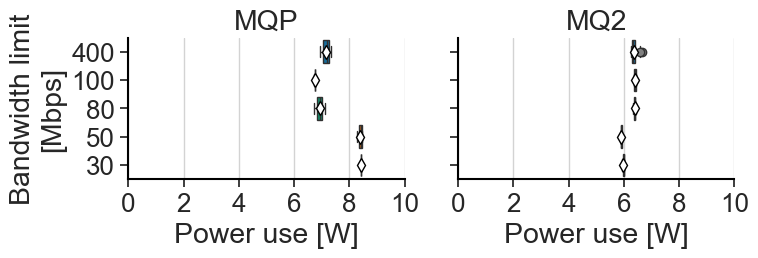

Quest-2 30 Mbps: 5.99 W
Quest-2 50 Mbps: 5.91 W
Quest-2 80 Mbps: 6.39 W
Quest-2 100 Mbps: 6.41 W
Quest-2 400 Mbps: 6.37 W
Max power decrease: 0.50 W
Max power decrease percent: 7.75%


In [33]:
fig, ax = plt.subplots(figsize=(8, 3), ncols=2, sharey=True)
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.7)

# to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro')]

to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro')]
to_plot['bw_text'] = to_plot['bandwidth'].apply(lambda x: '400' if x == 999999 else str(x))
to_plot.sort_values('bandwidth', ascending=False, inplace=True)

sns.boxplot(x=to_plot['Energy per Second (J/s)'], y=to_plot['bw_text'], showmeans=True, meanprops=custom_mean, palette="colorblind", ax=ax[0], flierprops=custom_outliers)

ax[0].set_xticks([0, 2, 4, 6, 8, 10])
ax[0].set_ylabel('Bandwidth limit\n[Mbps]')
ax[0].set_xlabel('Power use [W]')
ax[0].set_title('MQP')

qp_30Mbps = to_plot[to_plot['bandwidth'] == 30]['Energy per Second (J/s)'].mean()
qp_50Mbps = to_plot[to_plot['bandwidth'] == 50]['Energy per Second (J/s)'].mean()
qp_80Mbps = to_plot[to_plot['bandwidth'] == 80]['Energy per Second (J/s)'].mean()
qp_100Mbps = to_plot[to_plot['bandwidth'] == 100]['Energy per Second (J/s)'].mean()
qp_400Mbps = to_plot[to_plot['bandwidth'] == 999999]['Energy per Second (J/s)'].mean()

print(f'Quest-Pro 30 Mbps: {qp_30Mbps:.2f} W')
print(f'Quest-Pro 50 Mbps: {qp_50Mbps:.2f} W')
print(f'Quest-Pro 80 Mbps: {qp_80Mbps:.2f} W')
print(f'Quest-Pro 100 Mbps: {qp_100Mbps:.2f} W')
print(f'Quest-Pro 400 Mbps: {qp_400Mbps:.2f} W')

qp_max_power_increase = max([qp_30Mbps, qp_50Mbps, qp_80Mbps, qp_100Mbps, qp_400Mbps]) - min([qp_30Mbps, qp_50Mbps, qp_80Mbps, qp_100Mbps, qp_400Mbps])
print(f'Max power increase: {qp_max_power_increase:.2f} W')

qp_max_power_increase_percent = (qp_max_power_increase / min([qp_30Mbps, qp_50Mbps, qp_80Mbps, qp_100Mbps, qp_400Mbps])) * 100
print(f'Max power increase percent: {qp_max_power_increase_percent:.2f}%')


to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-2')]
to_plot['bw_text'] = to_plot['bandwidth'].apply(lambda x: '400' if x == 999999 else str(x))
to_plot.sort_values('bandwidth', ascending=False, inplace=True)

sns.boxplot(x=to_plot['Energy per Second (J/s)'], y=to_plot['bw_text'], showmeans=True, meanprops=custom_mean, palette="colorblind", ax=ax[1], flierprops=custom_outliers)

ax[1].set_xticks([0, 2, 4, 6, 8, 10])
ax[1].set_ylabel('Bandwidth limit\n[Mbps]')
ax[1].set_xlabel('Power use [W]')
ax[1].set_title('MQ2')

plt.tight_layout()
plt.savefig('./figures/energy/watts_vs_bandwidth.pdf', dpi=300, format='pdf')
plt.show()


q2_30Mbps = to_plot[to_plot['bandwidth'] == 30]['Energy per Second (J/s)'].mean()
q2_50Mbps = to_plot[to_plot['bandwidth'] == 50]['Energy per Second (J/s)'].mean()
q2_80Mbps = to_plot[to_plot['bandwidth'] == 80]['Energy per Second (J/s)'].mean()
q2_100Mbps = to_plot[to_plot['bandwidth'] == 100]['Energy per Second (J/s)'].mean()
q2_400Mbps = to_plot[to_plot['bandwidth'] == 999999]['Energy per Second (J/s)'].mean()

print(f'Quest-2 30 Mbps: {q2_30Mbps:.2f} W')
print(f'Quest-2 50 Mbps: {q2_50Mbps:.2f} W')
print(f'Quest-2 80 Mbps: {q2_80Mbps:.2f} W')
print(f'Quest-2 100 Mbps: {q2_100Mbps:.2f} W')
print(f'Quest-2 400 Mbps: {q2_400Mbps:.2f} W')

q2_max_power_decrease = max([q2_30Mbps, q2_50Mbps, q2_80Mbps, q2_100Mbps, q2_400Mbps]) - min([q2_30Mbps, q2_50Mbps, q2_80Mbps, q2_100Mbps, q2_400Mbps])
print(f'Max power decrease: {q2_max_power_decrease:.2f} W')

q2_max_power_decrease_percent = (q2_max_power_decrease / max([q2_30Mbps, q2_50Mbps, q2_80Mbps, q2_100Mbps, q2_400Mbps])) * 100
print(f'Max power decrease percent: {q2_max_power_decrease_percent:.2f}%')


# Investigating previous runs

./clumsy-bandwidth-100Mbps/Quest-Pro/BeatSaber/PopStars-Medium/replay1.0\battery_manager.csv
./clumsy-bandwidth-100Mbps/Quest-Pro/BeatSaber/PopStars-Medium/replay1.1\battery_manager.csv
./clumsy-bandwidth-100Mbps/Quest-Pro/BeatSaber/PopStars-Medium/replay1.2\battery_manager.csv
./clumsy-bandwidth-80Mbps/Quest-Pro/BeatSaber/PopStars-Medium/replay1.0\battery_manager.csv
./clumsy-bandwidth-80Mbps/Quest-Pro/BeatSaber/PopStars-Medium/replay1.1\battery_manager.csv
./clumsy-bandwidth-80Mbps/Quest-Pro/BeatSaber/PopStars-Medium/replay1.2\battery_manager.csv
./clumsy-bandwidth-50Mbps/Quest-Pro/BeatSaber/PopStars-Medium/replay1.0\battery_manager.csv
./clumsy-bandwidth-50Mbps/Quest-Pro/BeatSaber/PopStars-Medium/replay1.1\battery_manager.csv
./clumsy-bandwidth-50Mbps/Quest-Pro/BeatSaber/PopStars-Medium/replay1.2\battery_manager.csv
./clumsy-bandwidth-30Mbps/Quest-Pro/BeatSaber/PopStars-Medium/replay1.0\battery_manager.csv
./clumsy-bandwidth-30Mbps/Quest-Pro/BeatSaber/PopStars-Medium/replay1.1\batte

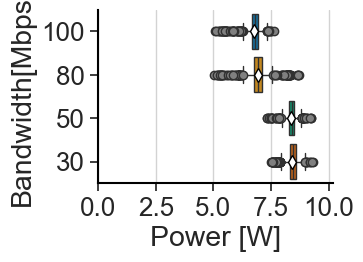

In [35]:
def read_battery_manager_by_device_and_bandwidth(device, bandwidth):
    df = pd.DataFrame()
    for root, dirs, files in os.walk(f'./clumsy-bandwidth-{bandwidth}Mbps/{device}/BeatSaber/PopStars-Medium/'):
        for name in files:
            if 'replay' in os.path.join(root, name):
                if name == 'battery_manager.csv':
                    print(os.path.join(root, name))
                    tmp = pd.read_csv(os.path.join(root, name))
                    df = pd.concat([df, tmp])
    df['bandwidth'] = str(bandwidth)
    return df

df = pd.DataFrame()
# '30', '50', '80', '100'
for bandwidth in ['100', '80', '50', '30']:
    df = pd.concat([df, read_battery_manager_by_device_and_bandwidth('Quest-Pro', bandwidth)])

# boxplot power for bla
fig, ax = plt.subplots(figsize=(4, 3))
sns.set_theme(style="whitegrid", font_scale=1.6)

sns.boxplot(x=df['power'], y=df['bandwidth'], showmeans=True, meanprops=custom_mean, palette='colorblind', flierprops=custom_outliers, ax=ax)

ax.set_xlim(0, 10.2)
ax.set_xticks([0, 2.5, 5, 7.5, 10])
ax.set_ylabel('Bandwidth[Mbps]')
ax.set_xlabel('Power [W]')
plt.tight_layout()
plt.show()

In [44]:
def get_battery_level(path):
    with open(f'{path}\\battery.log', 'r', encoding='utf-16-le') as f:
        f.seek(0)
        battery_level1 = re.findall(r'level: (\d+)', f.read())[0]
        f.seek(0)
        battery_level2 = re.findall(r'level: (\d+)', f.read())[-1]
        return battery_level1, battery_level2
get_battery_level('clumsy-bandwidth-100Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\replay1.0')

('26', '23')

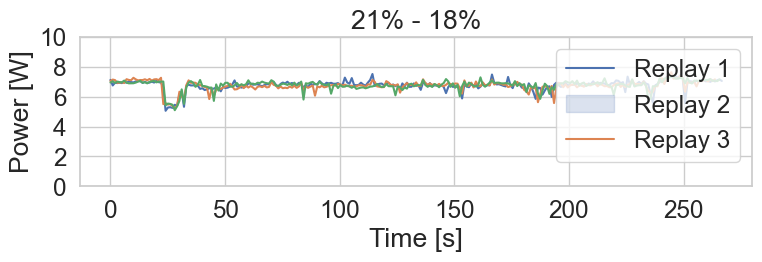

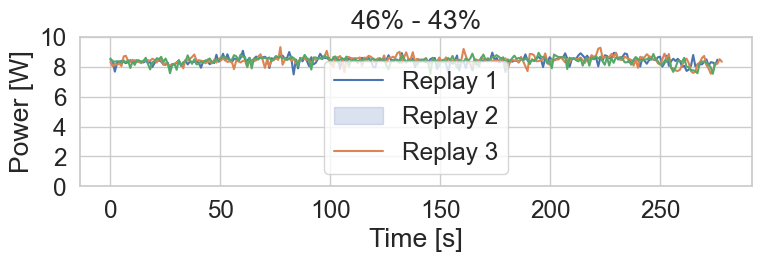

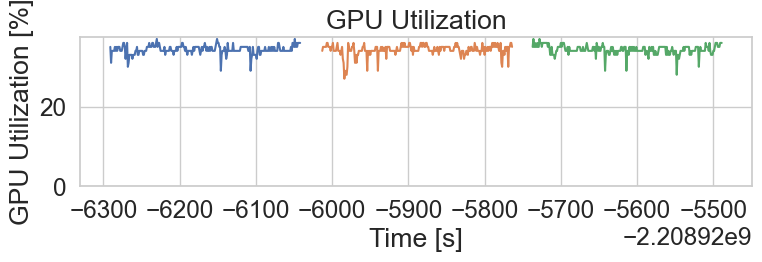

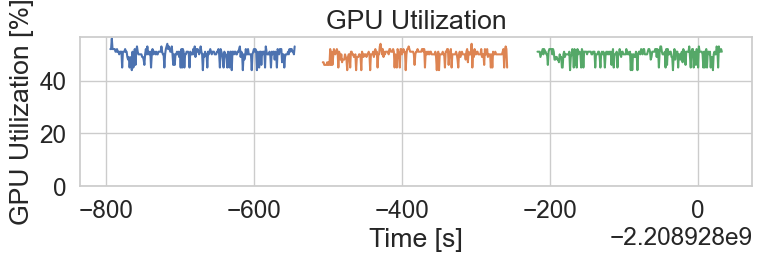

In [55]:
def lineplot_battery_by_csv(path):
    
    fig, ax = plt.subplots(figsize=(8, 3))
    sns.set_theme(style="whitegrid", font_scale=1.6)

    for i in range(0,3):
        battery_start, battery_end = get_battery_level(path + str(i))
        wa = pd.read_csv(path + str(i) + '\\battery_manager.csv')
        sns.lineplot(data=wa, x='Timestamp', y='power', ax=ax)

    ax.set_ylim(0, 9)
    ax.set_yticks([0, 2, 4, 6, 8, 10])
    ax.set_ylabel('Power [W]')
    ax.set_xlabel('Time [s]')
    plt.title(f'{battery_start}% - {battery_end}%')

    # Add legend
    plt.legend(['Replay 1', 'Replay 2', 'Replay 3'])

    plt.tight_layout()

    plt.show()

lineplot_battery_by_csv('clumsy-bandwidth-100Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\replay1.')
lineplot_battery_by_csv('clumsy-bandwidth-30Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\replay1.')

# lineplot_battery_by_csv('clumsy-bandwidth-100Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\replicate0.1')
# lineplot_battery_by_csv('clumsy-bandwidth-100Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\replicate0.2')
                


############################ GPU stuff ############################

def lineplot_gpu_by_csv(path):
    fig, ax = plt.subplots(figsize=(8, 3))
    sns.set_theme(style="whitegrid", font_scale=1.6)

    for i in range(0,3):
        wa = pd.read_csv(path + str(i) + '\\logcat_VrApi.csv')
        wa['GPU%'] = wa['GPU%'] * 100
        sns.lineplot(data=wa, x='timestamp', y='GPU%', ax=ax)

    ax.set_ylim(0)
    # ax.set_yticks([0, 2, 4, 6, 8, 10])
    ax.set_ylabel('GPU Utilization [%]')
    ax.set_xlabel('Time [s]')
    plt.title(f'GPU Utilization')
    plt.tight_layout()
    # plt.legend(['Replay 1', 'Replay 2', 'Replay 3'])

    plt.show()


lineplot_gpu_by_csv('clumsy-bandwidth-100Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\replay1.')
lineplot_gpu_by_csv('clumsy-bandwidth-30Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\replay1.')

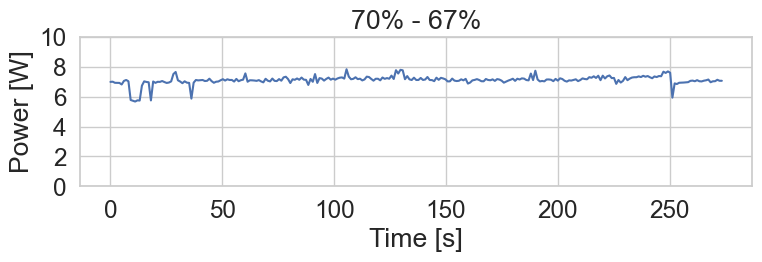

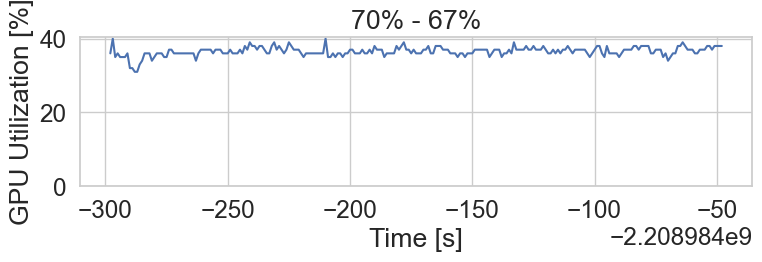

In [11]:
wa = pd.read_csv('clumsy-bandwidth-100Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\29-02\\replicate0.0-pcd\\battery_manager.csv')
fig, ax = plt.subplots(figsize=(8, 3))
sns.set_theme(style="whitegrid", font_scale=1.6)

sns.lineplot(data=wa, x='Timestamp', y='power', ax=ax)

ax.set_ylim(0, 9)
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.set_ylabel('Power [W]')
ax.set_xlabel('Time [s]')
plt.title('70% - 67%')
plt.tight_layout()

plt.show()

gpu_wa = pd.read_csv('clumsy-bandwidth-100Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\29-02\\replicate0.0-pcd\\logcat_VrApi.csv')
gpu_wa['GPU%'] = gpu_wa['GPU%'] * 100

fig, ax = plt.subplots(figsize=(8, 3))
sns.set_theme(style="whitegrid", font_scale=1.6)

sns.lineplot(data=gpu_wa, x='timestamp', y='GPU%', ax=ax)

ax.set_ylim(0)
# ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.set_ylabel('GPU Utilization [%]')
ax.set_xlabel('Time [s]')
plt.title('70% - 67%')
plt.tight_layout()

plt.show()

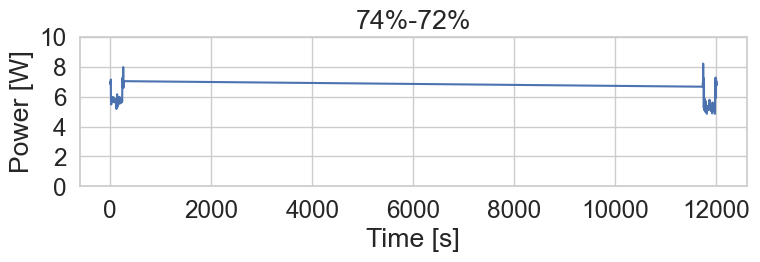

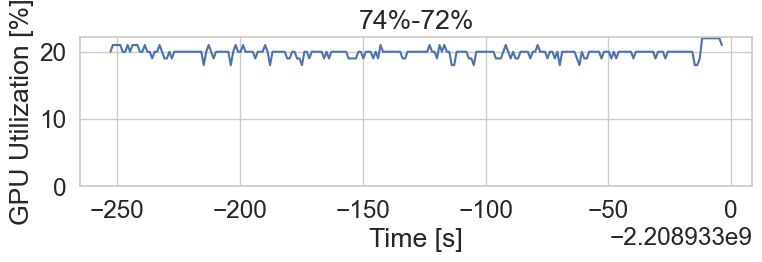

In [12]:
wa = pd.read_csv('clumsy-bandwidth-100Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\replicate0.0 copy\\battery_manager.csv')
wa['Timestamp'] = wa['Timestamp'] - wa['Timestamp'][0]
# plot power over time
fig, ax = plt.subplots(figsize=(8, 3))
sns.set_theme(style="whitegrid", font_scale=1.6)

sns.lineplot(data=wa, x='Timestamp', y='power', ax=ax)

ax.set_ylim(0, 9)
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.set_ylabel('Power [W]')
ax.set_xlabel('Time [s]')
plt.title('74%-72%')
plt.tight_layout()

plt.show()

gpu_wa = pd.read_csv('clumsy-bandwidth-100Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\replicate0.0 copy\\logcat_VrApi.csv')
gpu_wa['GPU%'] = gpu_wa['GPU%'] * 100

fig, ax = plt.subplots(figsize=(8, 3))
sns.set_theme(style="whitegrid", font_scale=1.6)

sns.lineplot(data=gpu_wa, x='timestamp', y='GPU%', ax=ax)

ax.set_ylim(0)
# ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.set_ylabel('GPU Utilization [%]')
ax.set_xlabel('Time [s]')
plt.title('74%-72%')
plt.tight_layout()

plt.show()

# Ew 2

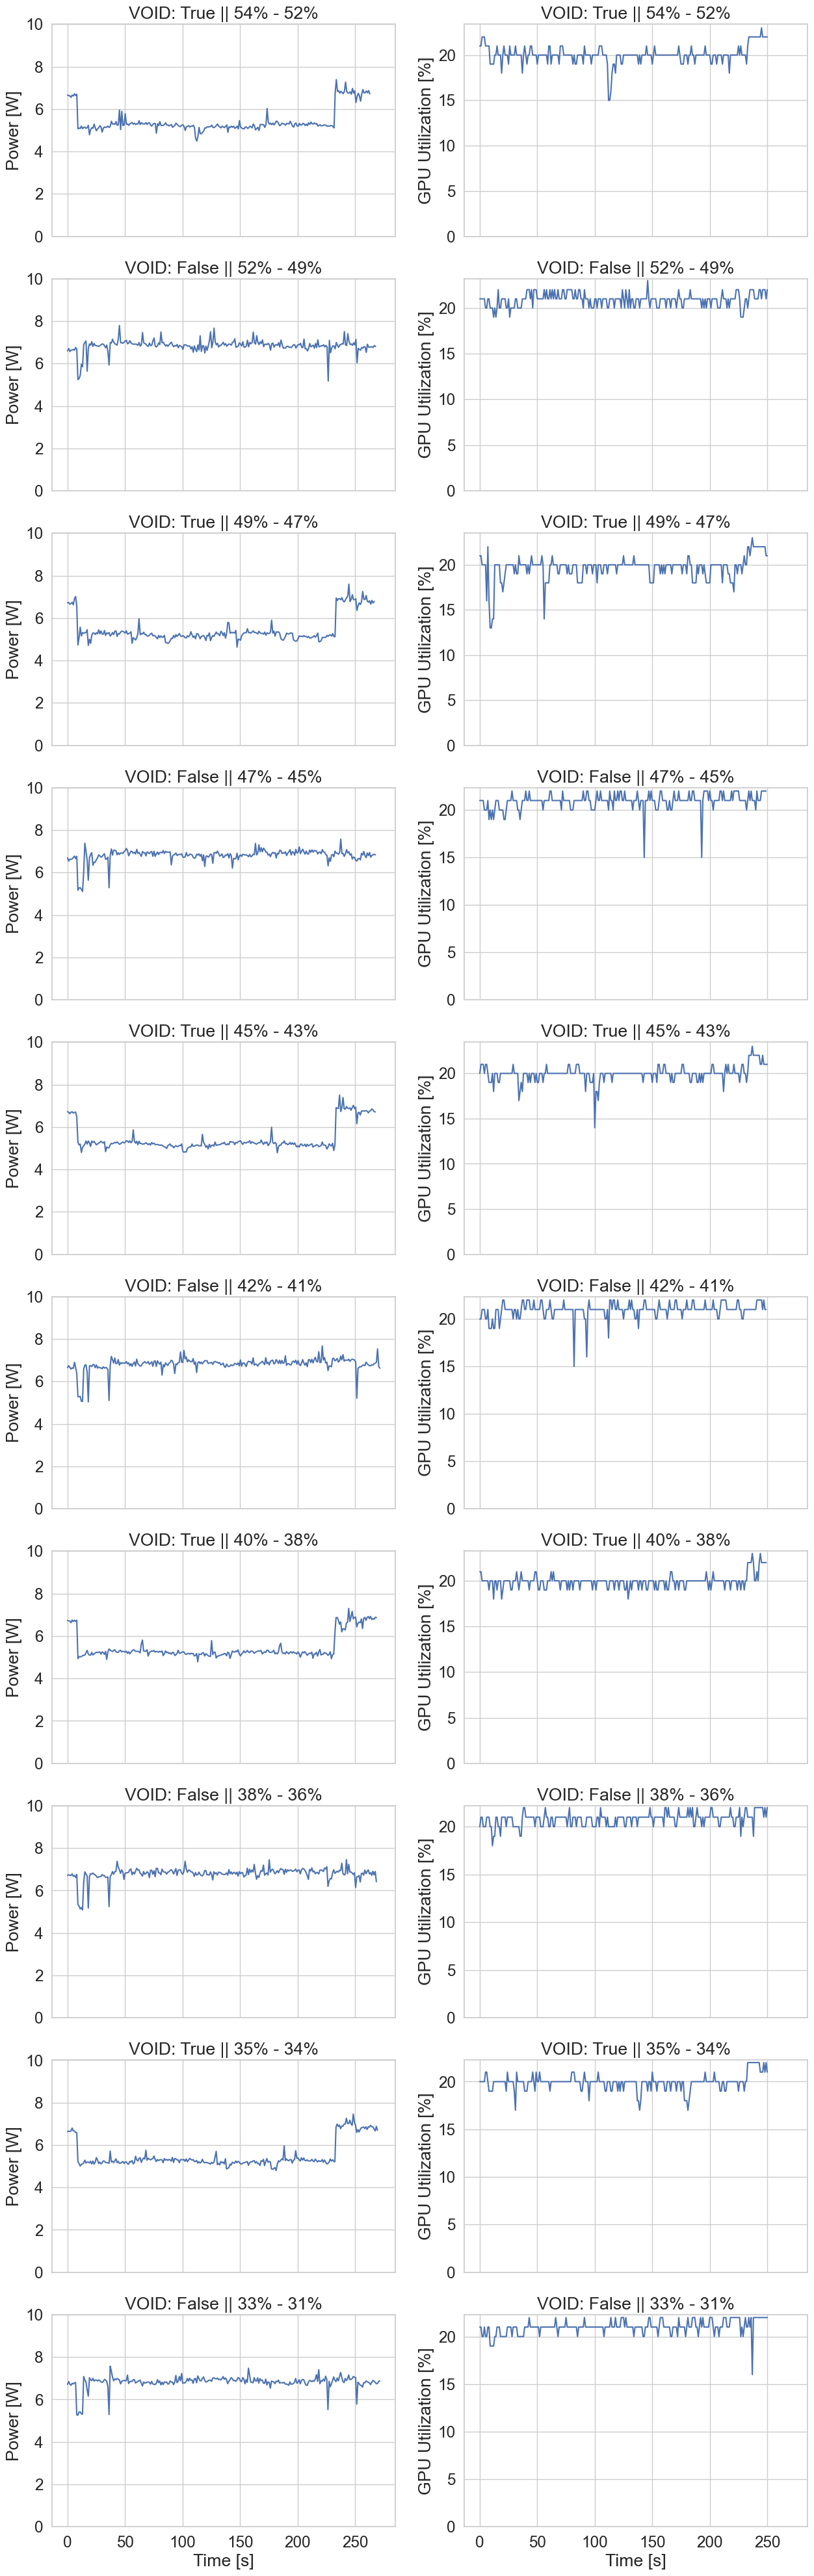

In [14]:
def plot_power_gpu(path, param, isparam, power_plot, gpu_plot):
    battery_start, battery_end = get_battery_level(path)
    # fig, ax = plt.subplots(figsize=(8, 3))
    wa = pd.read_csv(f'{path}\\battery_manager.csv')
    wa['Timestamp'] = wa['Timestamp'] - wa['Timestamp'][0]
    # plot power over time
    sns.set_theme(style="whitegrid", font_scale=1.6)

    sns.lineplot(data=wa, x='Timestamp', y='power', ax=power_plot)

    power_plot.set_ylim(0, 9)
    power_plot.set_yticks([0, 2, 4, 6, 8, 10])
    power_plot.set_ylabel('Power [W]')
    power_plot.set_xlabel('Time [s]')
    power_plot.set_title(f'{param}: {isparam} || {battery_start}% - {battery_end}%')

    # plt.title(f'{param}: {isparam} || {battery_start}% - {battery_end}%')
    # plt.tight_layout()

    # plt.show()

    gpu_wa = pd.read_csv(f'{path}\\logcat_VrApi.csv')
    gpu_wa['timestamp'] = gpu_wa['timestamp'] - gpu_wa['timestamp'][0]
    gpu_wa['GPU%'] = gpu_wa['GPU%'] * 100

    # fig, ax = plt.subplots(figsize=(8, 3))
    sns.set_theme(style="whitegrid", font_scale=1.6)

    sns.lineplot(data=gpu_wa, x='timestamp', y='GPU%', ax=gpu_plot)

    gpu_plot.set_ylim(0)
    # gpu_plot.set_yticks([0, 2, 4, 6, 8, 10])
    gpu_plot.set_ylabel('GPU Utilization [%]')
    gpu_plot.set_xlabel('Time [s]')
    gpu_plot.set_title(f'{param}: {isparam} || {battery_start}% - {battery_end}%')
    # plt.title(f'{param}: {isparam} || {battery_start}% - {battery_end}%')
    # plt.tight_layout()

    # plt.show()

# func(path, True)
# for repetition in [0,1,2,3,4,5,6,7,8,9]:
#     plot_power_gpu(f'clumsy-bandwidth-100Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\{param}_exp0.{repetition}', repetition%2==0)

# put all graphs in one figure
fig, ax = plt.subplots(10, 2, figsize=(15, 50), sharex=True)
for repetition in [0,1,2,3,4,5,6,7,8,9]:
    plot_power_gpu(f'clumsy-bandwidth-100Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\void_exp0.{repetition}', 'VOID', repetition%2==0, ax[repetition][0], ax[repetition][1])

# plt.tight_layout()
plt.show()


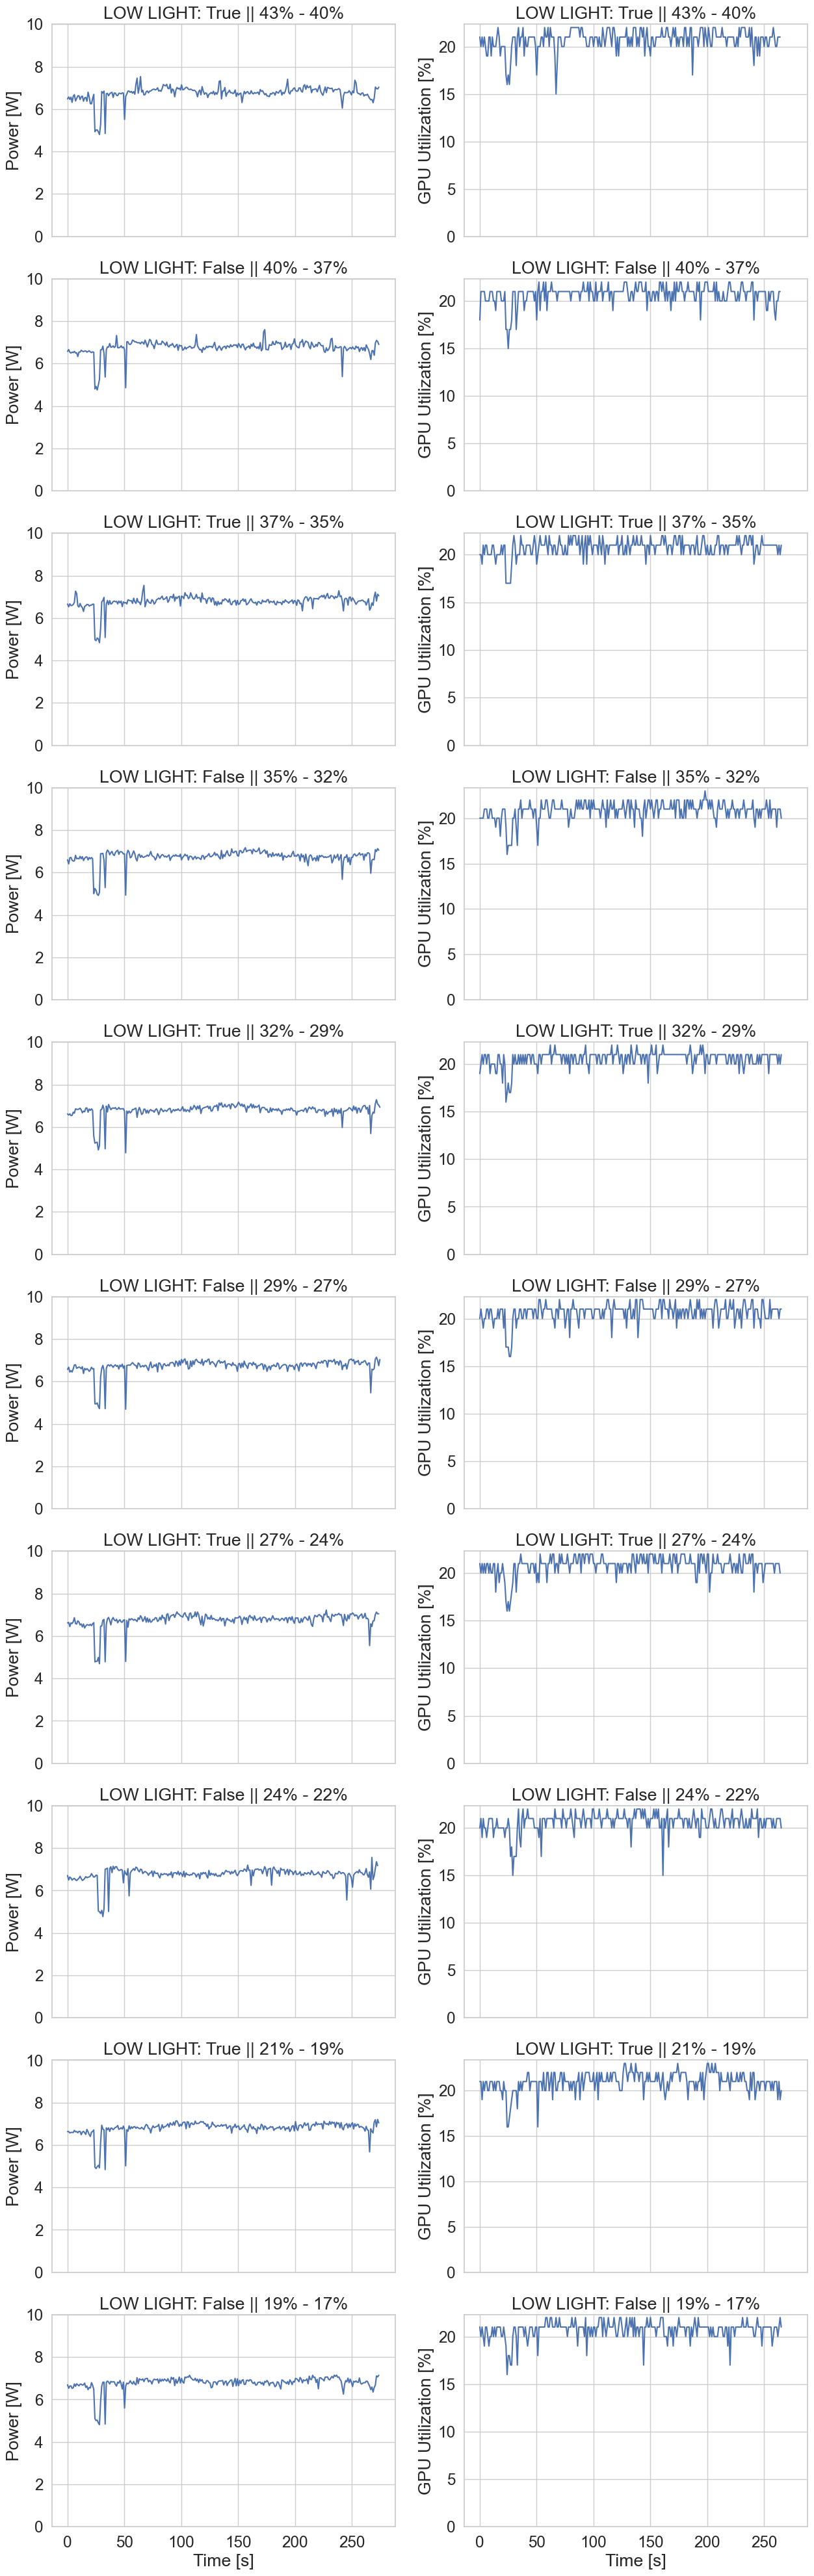

In [15]:
fig, ax = plt.subplots(10, 2, figsize=(15, 50), sharex=True)
for repetition in [0,1,2,3,4,5,6,7,8,9]:
    plot_power_gpu(f'clumsy-bandwidth-100Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\low_light_novoid0.{repetition}', 'LOW LIGHT', repetition%2==0, ax[repetition][0], ax[repetition][1])

plt.show()

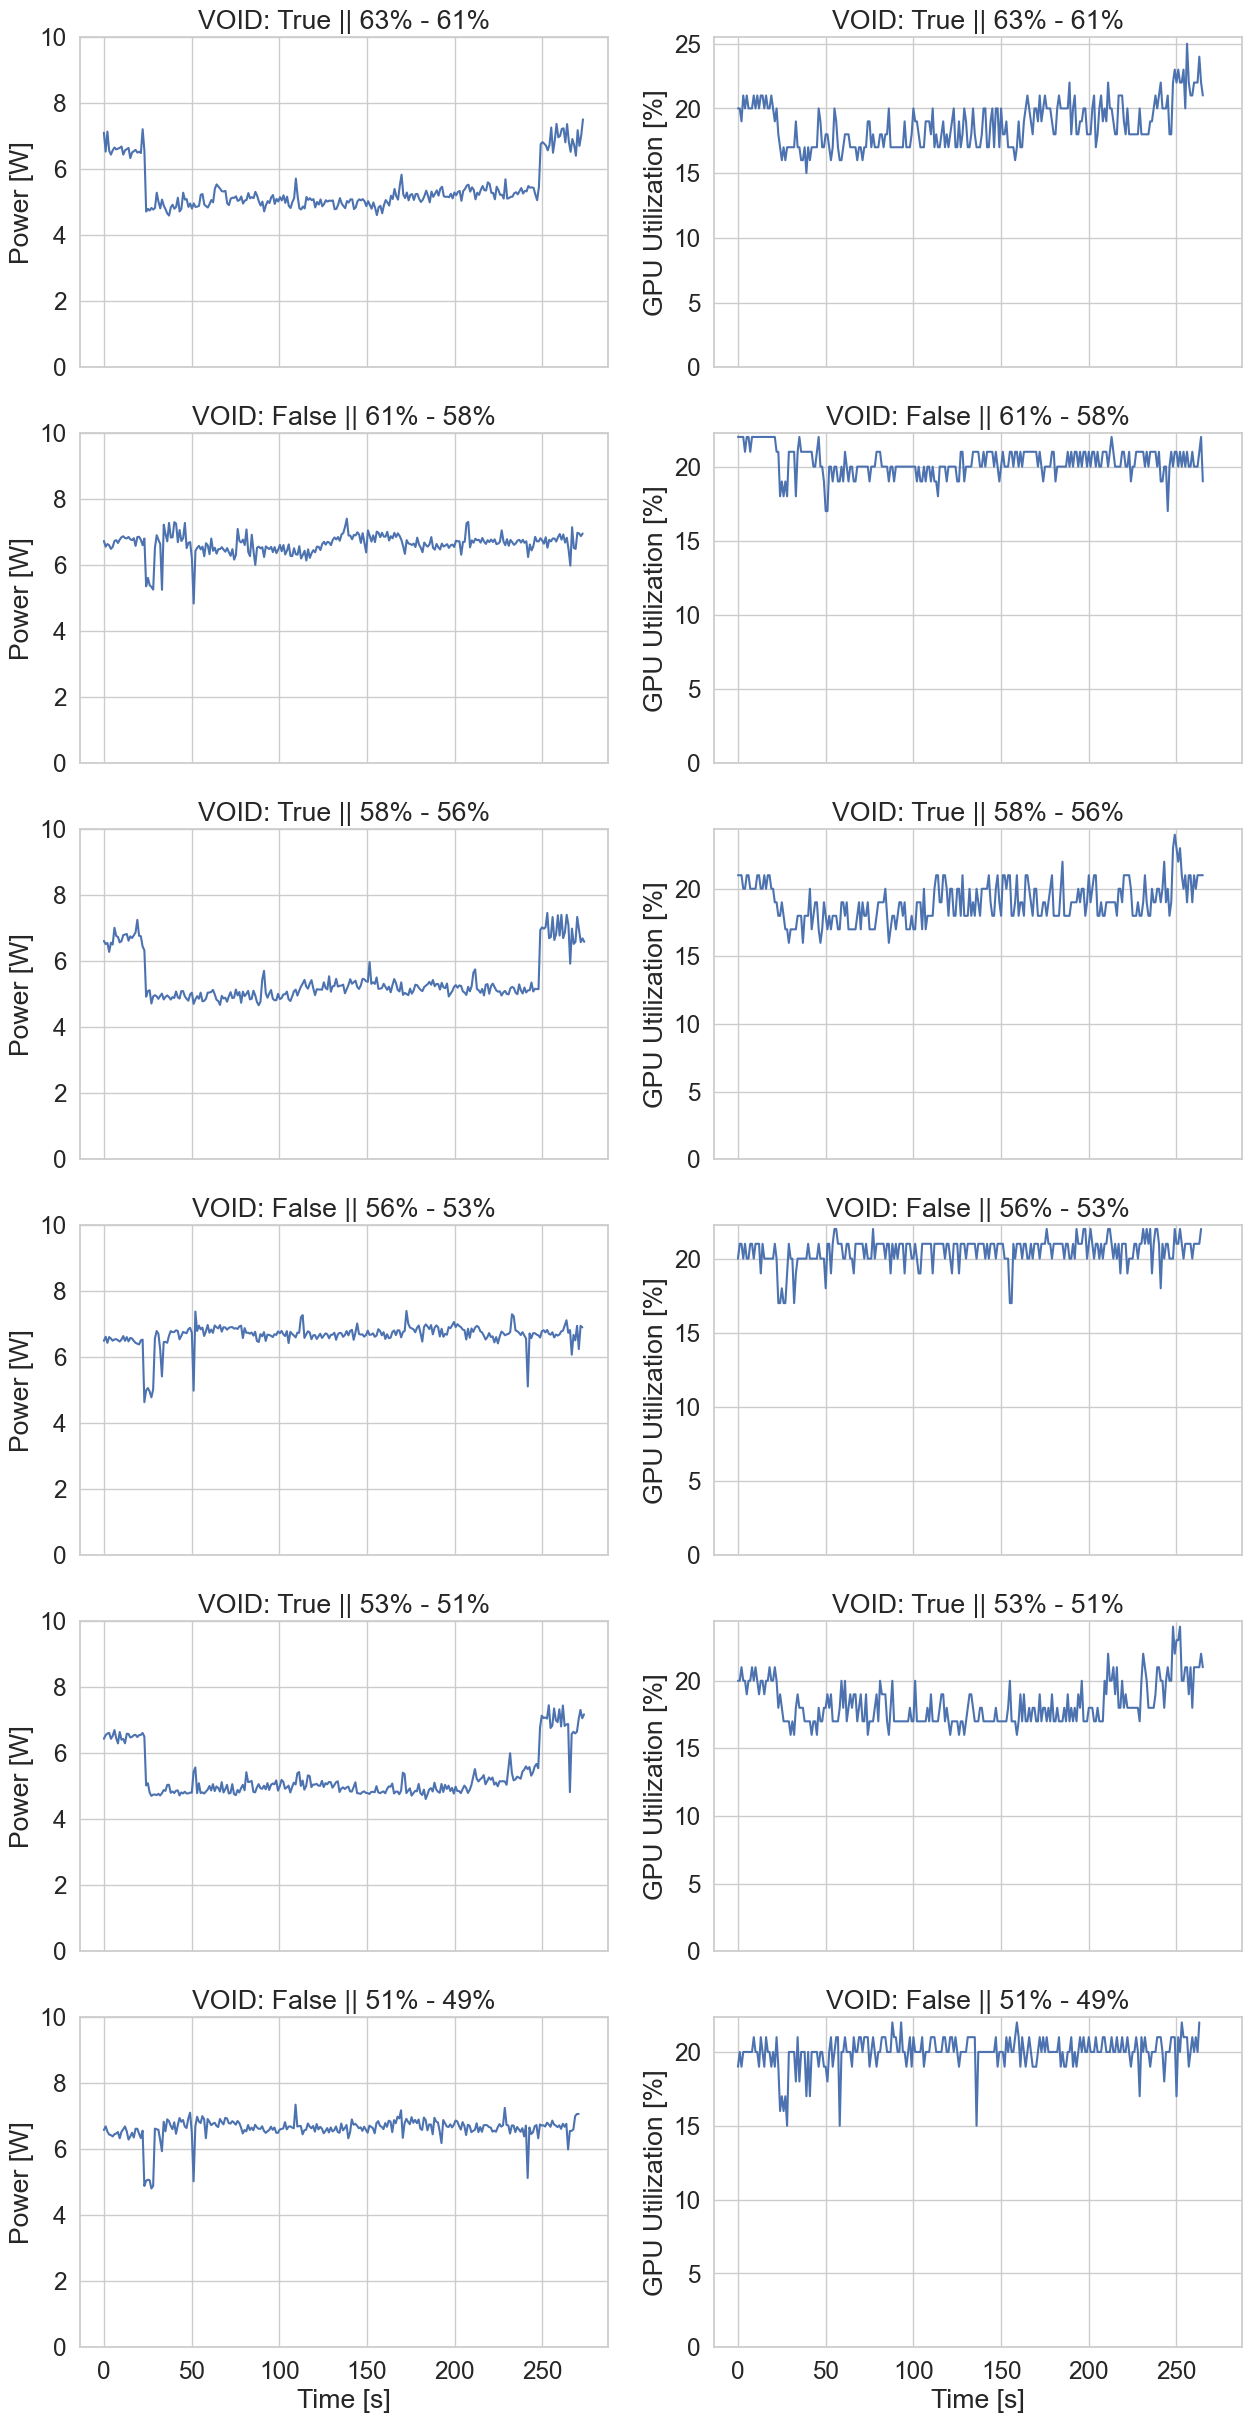

In [16]:
fig, ax = plt.subplots(6, 2, figsize=(15, 30), sharex=True)
for repetition in [0,1,2,3,4,5]:
    plot_power_gpu(f'clumsy-bandwidth-100Mbps\\Quest-Pro\\BeatSaber\\PopStars-Medium\\low_light0.{repetition}', 'VOID', repetition%2==0, ax[repetition][0], ax[repetition][1])

plt.show()

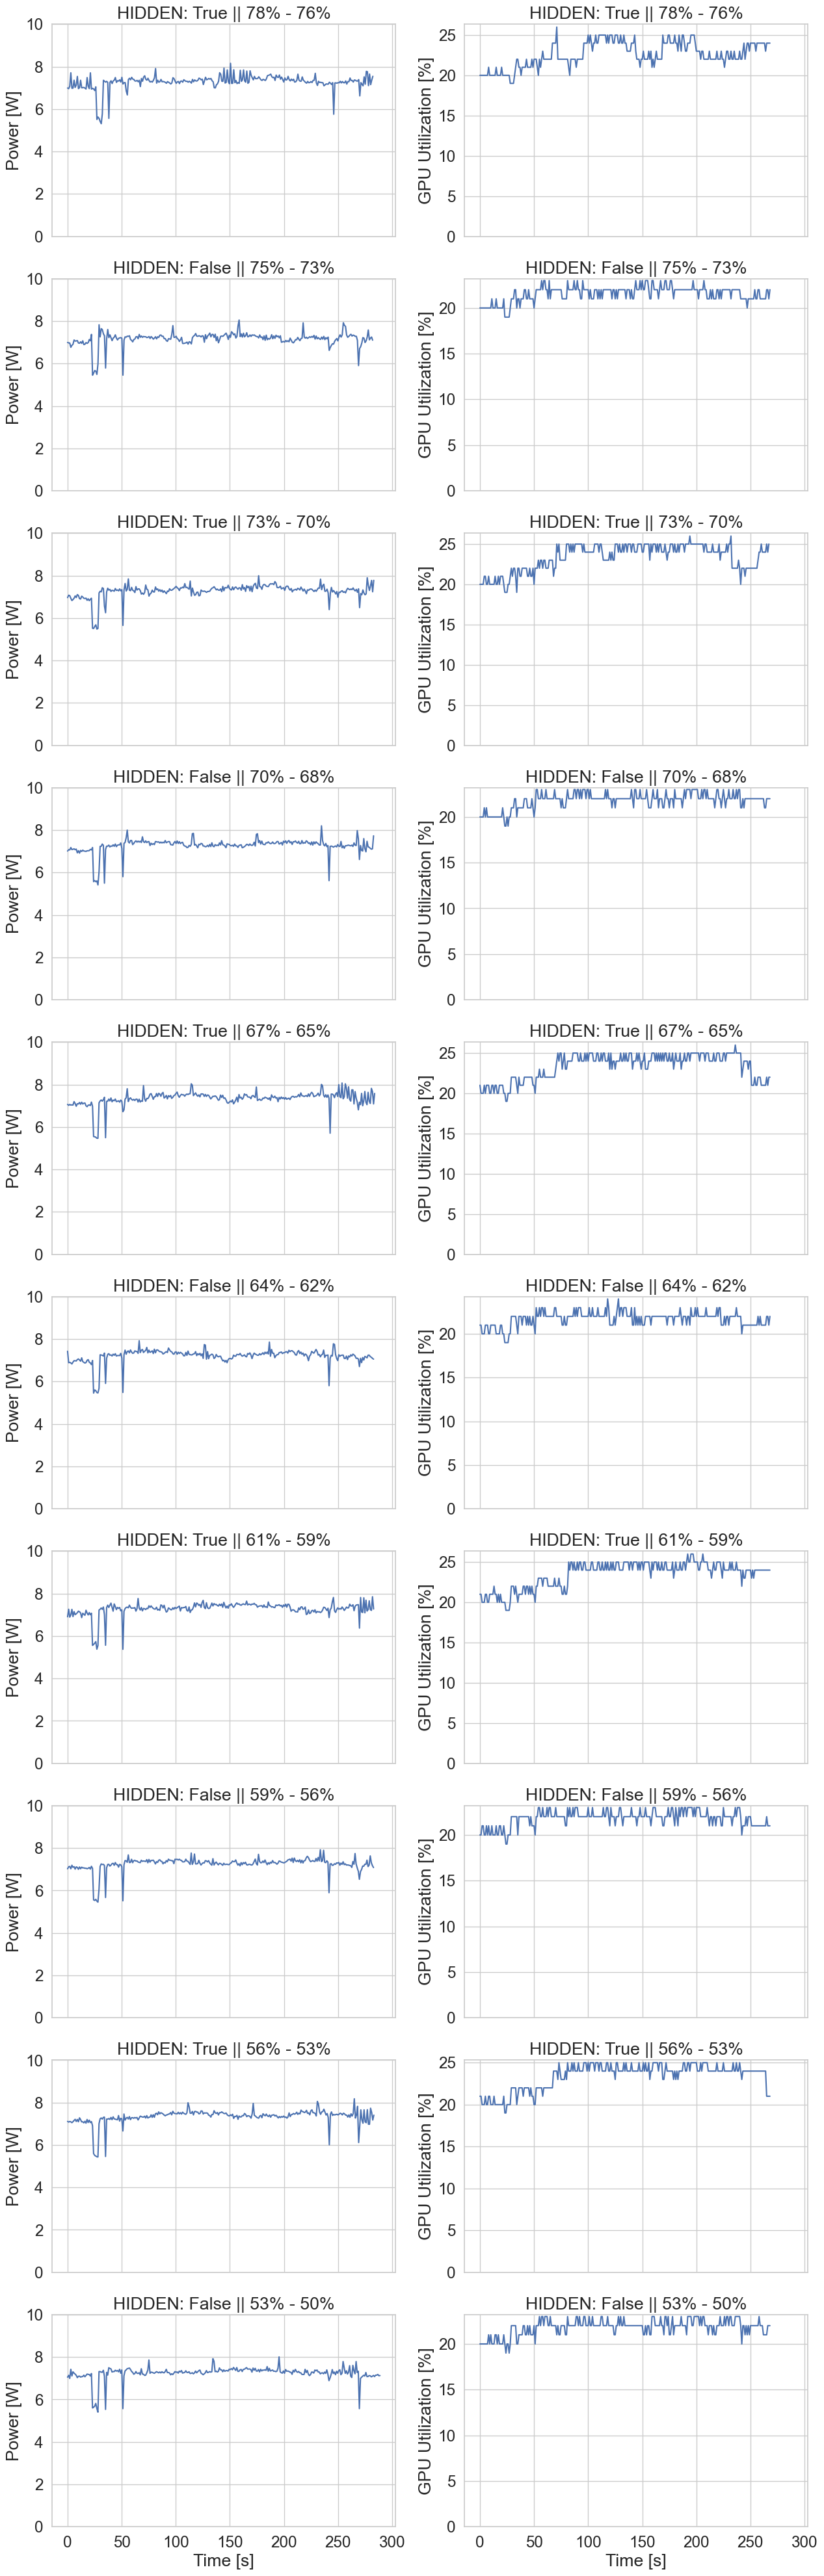

In [17]:
fig, ax = plt.subplots(10, 2, figsize=(15, 50), sharex=True)
for repetition in [0,1,2,3,4,5,6,7,8,9]:
    plot_power_gpu(f'investigation\\Quest-Pro\\BeatSaber\\PopStars-Medium\\hide_controllers0.{repetition}', 'HIDDEN', repetition%2==0, ax[repetition][0], ax[repetition][1])

plt.show()

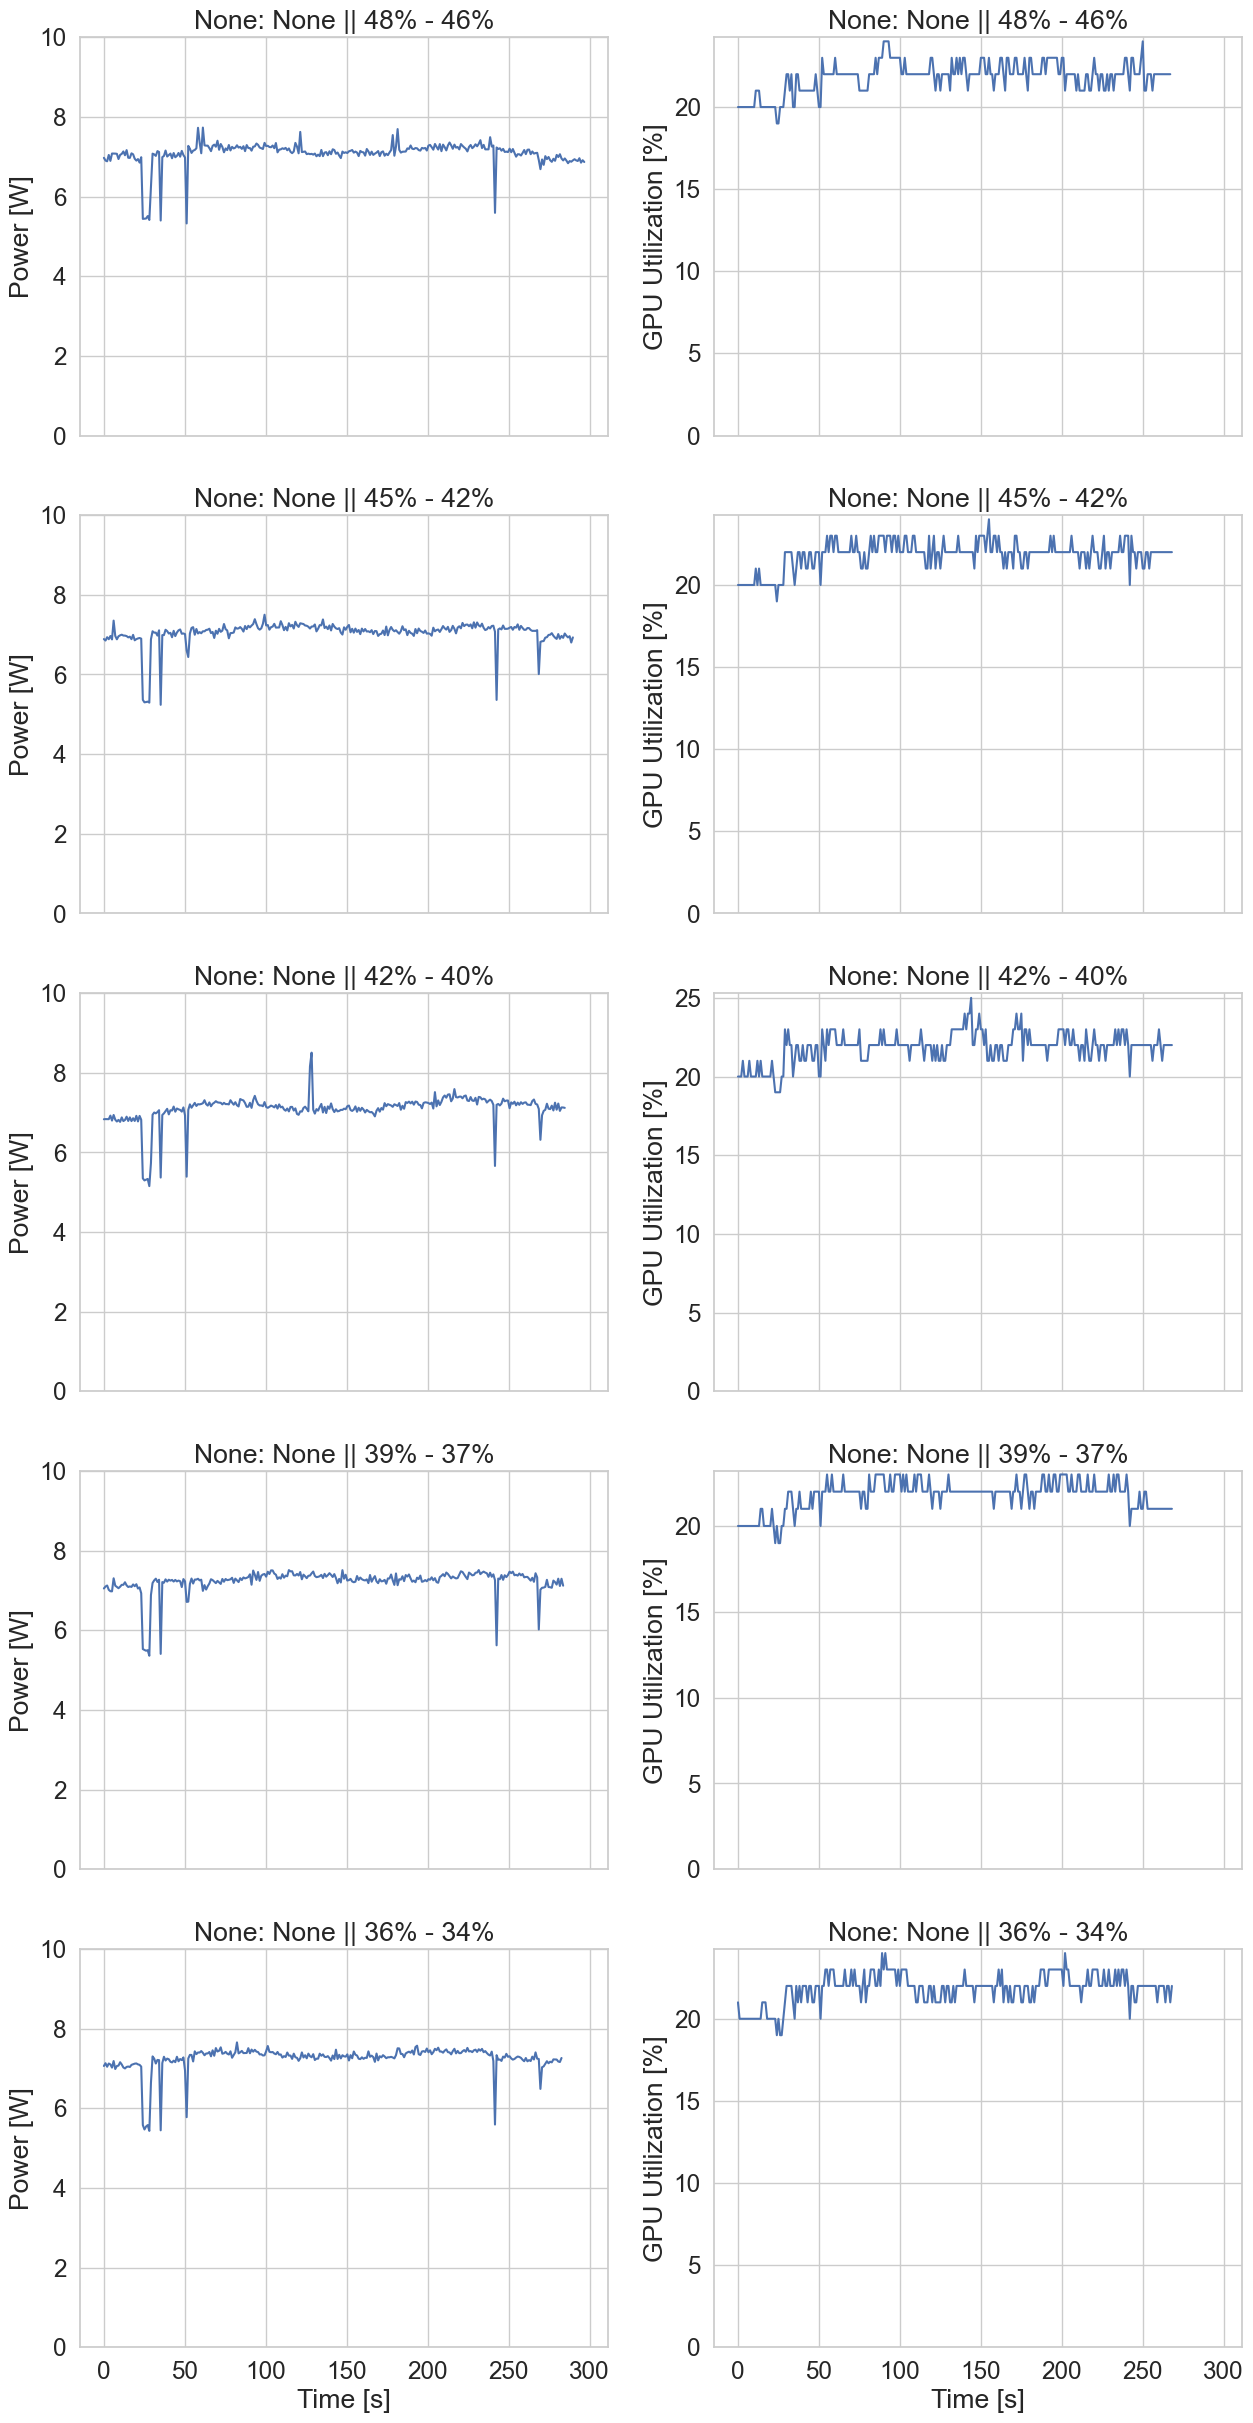

In [18]:
fig, ax = plt.subplots(5, 2, figsize=(15, 30), sharex=True)
for repetition in [0,1,2,3,4]:
    plot_power_gpu(f'investigation\\Quest-Pro\\BeatSaber\\PopStars-Medium\\no_boundary0.{repetition}', None, None, ax[repetition][0], ax[repetition][1])

plt.show()

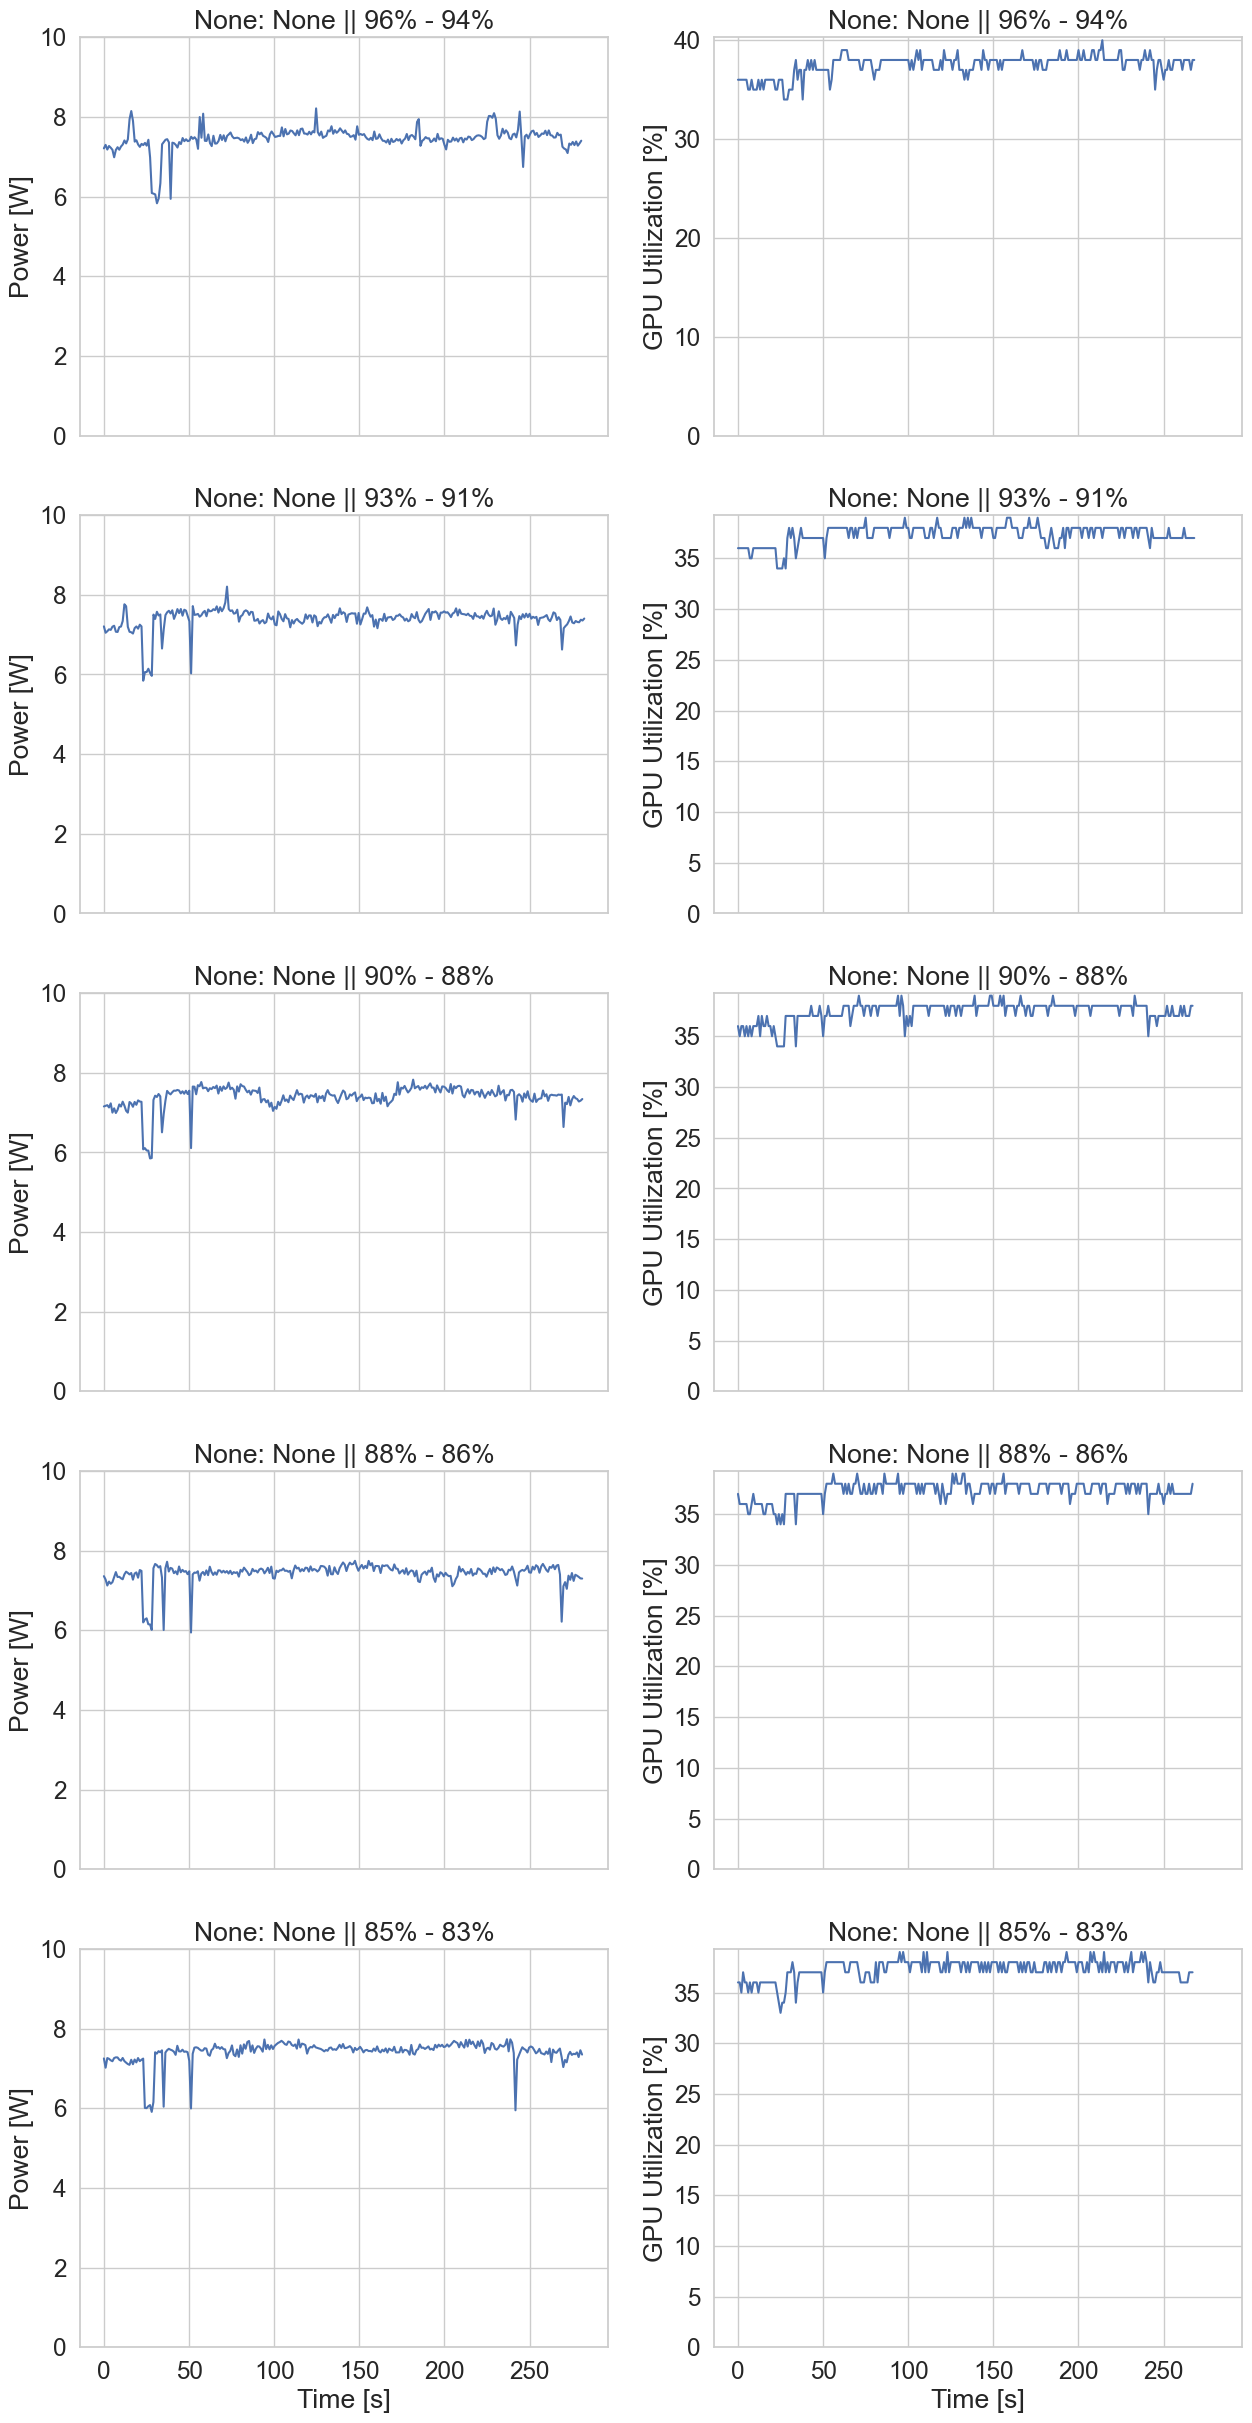

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(15, 30), sharex=True)
for repetition in [0,1,2,3,4]:
    plot_power_gpu(f'investigation\\Quest-Pro\\BeatSaber\\PopStars-Medium\\stationary_boundary0.{repetition}', None, None, ax[repetition][0], ax[repetition][1])

plt.show()

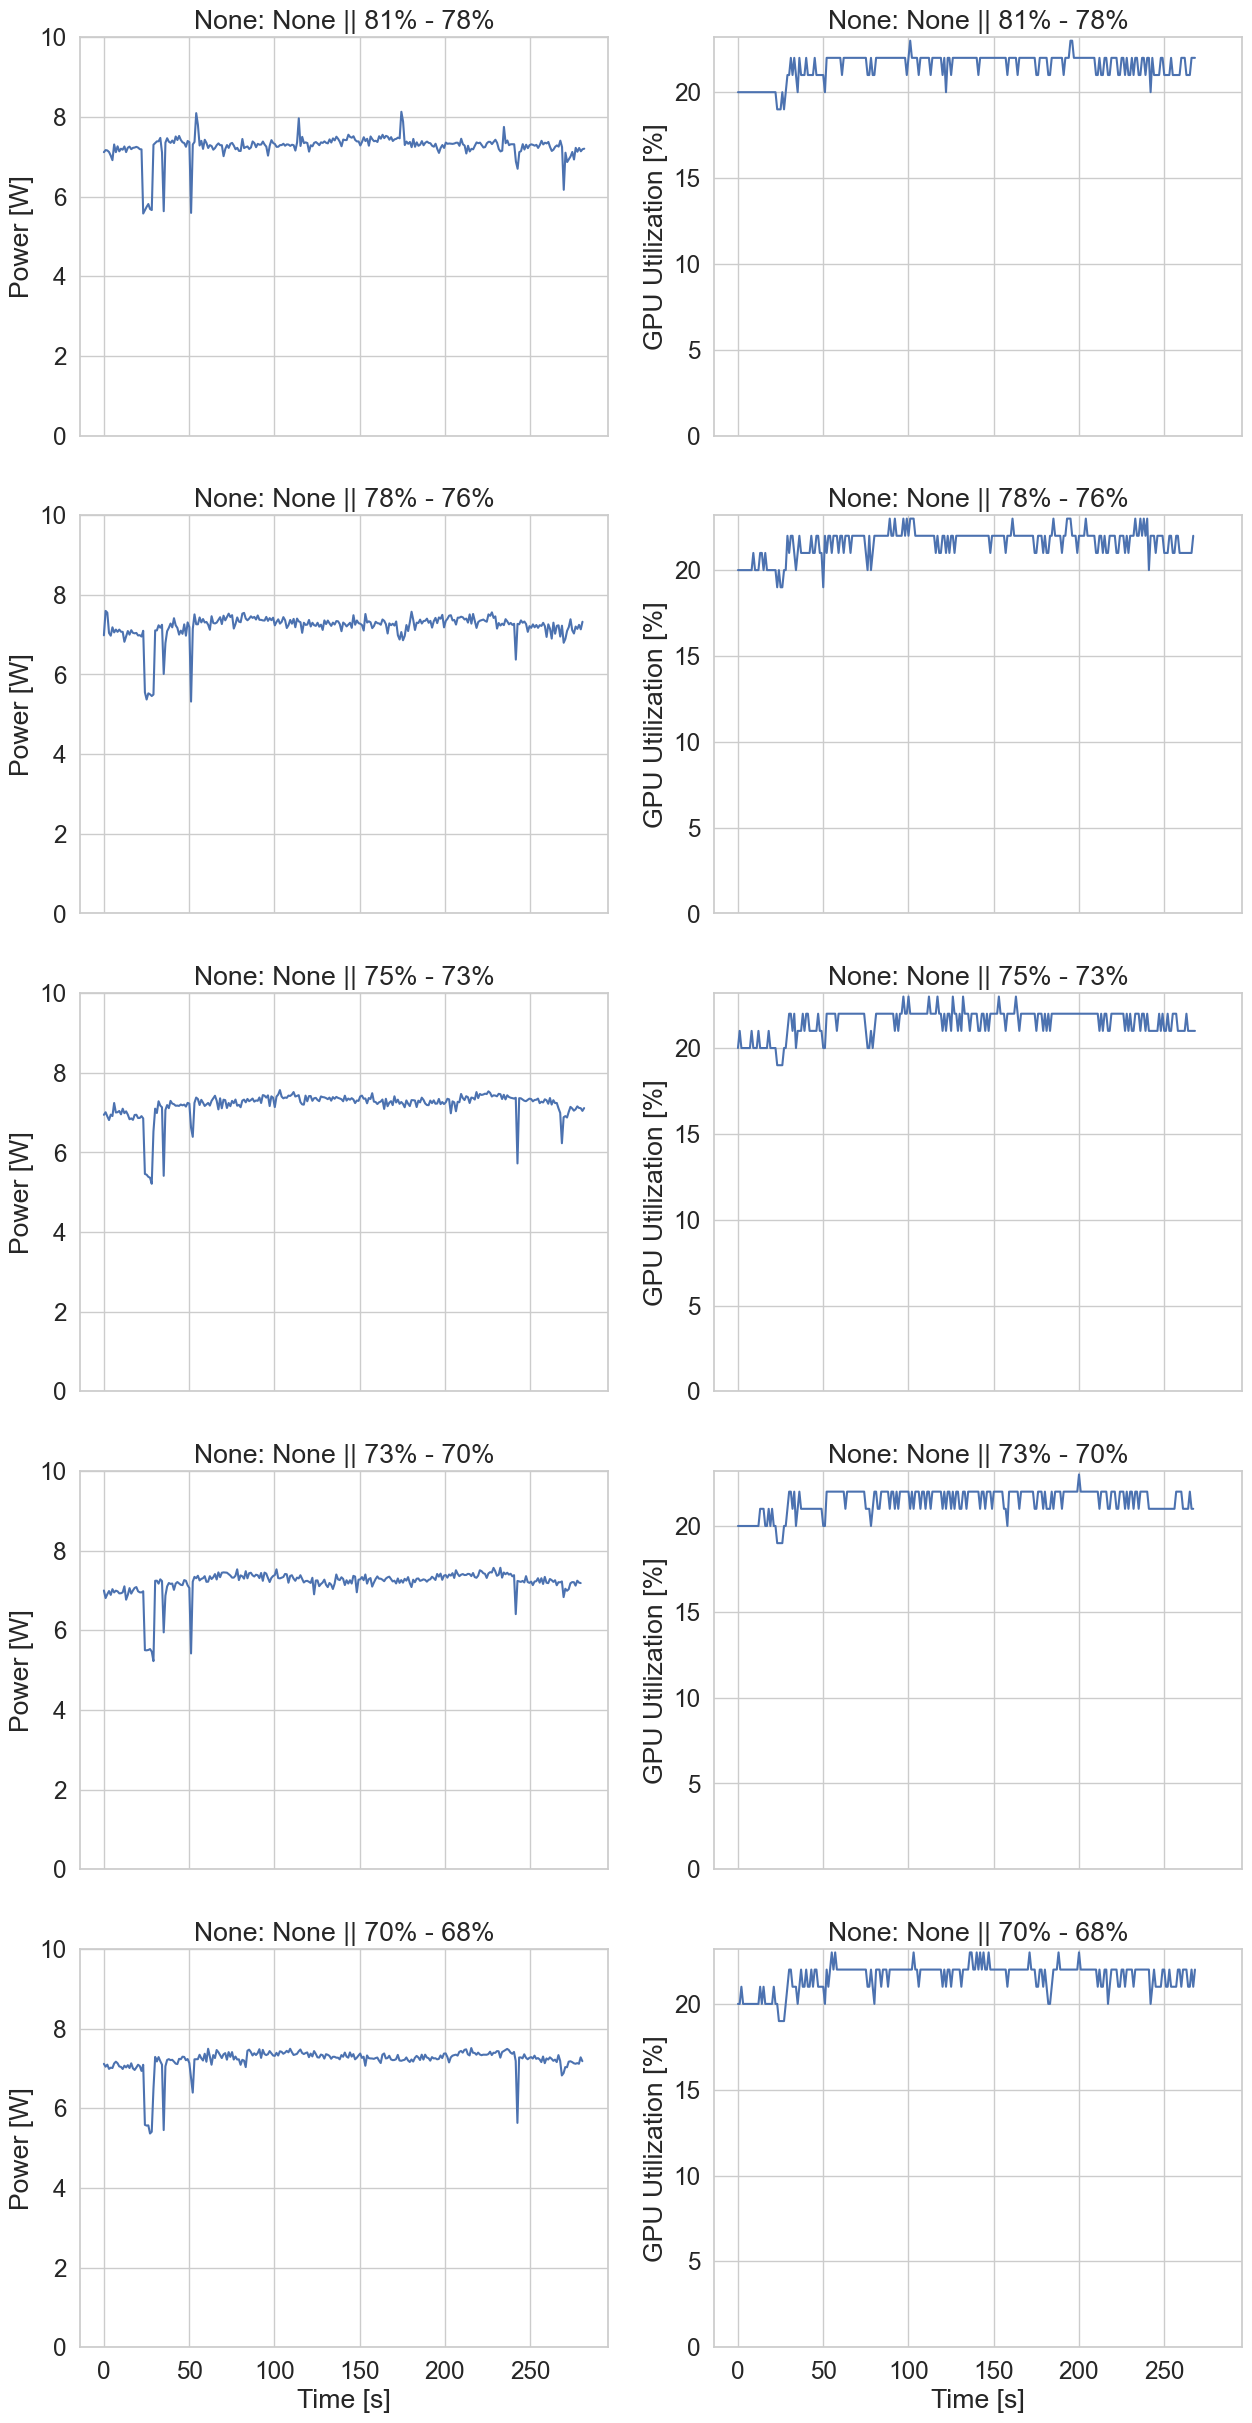

In [20]:
fig, ax = plt.subplots(5, 2, figsize=(15, 30), sharex=True)
for repetition in [0,1,2,3,4]:
    plot_power_gpu(f'investigation\\Quest-Pro\\BeatSaber\\PopStars-Medium\\roomscale_boundary0.{repetition}', None, None, ax[repetition][0], ax[repetition][1])

plt.show()

C:\Users\damla\AppData\Local\Temp\ipykernel_18388\3451706393.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=power_df, y='boundary', x='power', showmeans=True, meanprops=custom_mean, palette='colorblind', flierprops=custom_outliers, ax=ax[0])
C:\Users\damla\AppData\Local\Temp\ipykernel_18388\3451706393.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gpu_df, y='boundary', x='GPU%', showmeans=True, meanprops=custom_mean, palette='colorblind', flierprops=custom_outliers, ax=ax[1])


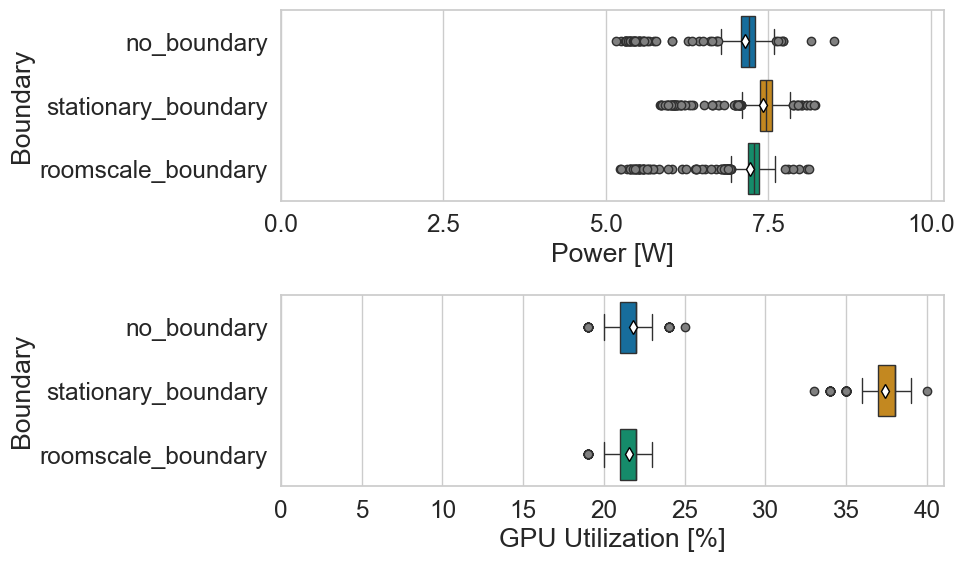

In [21]:
power_df = pd.DataFrame()
gpu_df = pd.DataFrame()
for boundary in ['no_boundary', 'stationary_boundary', 'roomscale_boundary']:
    for repetition in [0,1,2,3,4]:
        path = f'investigation\\Quest-Pro\\BeatSaber\\PopStars-Medium\\{boundary}0.{repetition}'
        
        wa = pd.read_csv(f'{path}\\battery_manager.csv')
        wa['Timestamp'] = wa['Timestamp'] - wa['Timestamp'][0]
        wa['boundary'] = boundary
        power_df = pd.concat([power_df, wa])

        gpu_wa = pd.read_csv(f'{path}\\logcat_VrApi.csv')
        gpu_wa['timestamp'] = gpu_wa['timestamp'] - gpu_wa['timestamp'][0]
        gpu_wa['GPU%'] = gpu_wa['GPU%'] * 100
        gpu_wa['boundary'] = boundary
        gpu_df = pd.concat([gpu_df, gpu_wa])

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.set_theme(style="whitegrid", font_scale=1.6)

sns.boxplot(data=power_df, y='boundary', x='power', showmeans=True, meanprops=custom_mean, palette='colorblind', flierprops=custom_outliers, ax=ax[0])
ax[0].set_xlim(0, 10.2)
ax[0].set_xticks([0, 2.5, 5, 7.5, 10])
ax[0].set_ylabel('Boundary')
ax[0].set_xlabel('Power [W]')

sns.boxplot(data=gpu_df, y='boundary', x='GPU%', showmeans=True, meanprops=custom_mean, palette='colorblind', flierprops=custom_outliers, ax=ax[1])
ax[1].set_xlim(0)
ax[1].set_ylabel('Boundary')
ax[1].set_xlabel('GPU Utilization [%]')
plt.tight_layout()
plt.show()

C:\Users\damla\AppData\Local\Temp\ipykernel_18388\791312537.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=power_df, y='controllers', x='power', showmeans=True, meanprops=custom_mean, palette='colorblind', flierprops=custom_outliers, ax=ax[0])
C:\Users\damla\AppData\Local\Temp\ipykernel_18388\791312537.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gpu_df, y='controllers', x='GPU%', showmeans=True, meanprops=custom_mean, palette='colorblind', flierprops=custom_outliers, ax=ax[1])


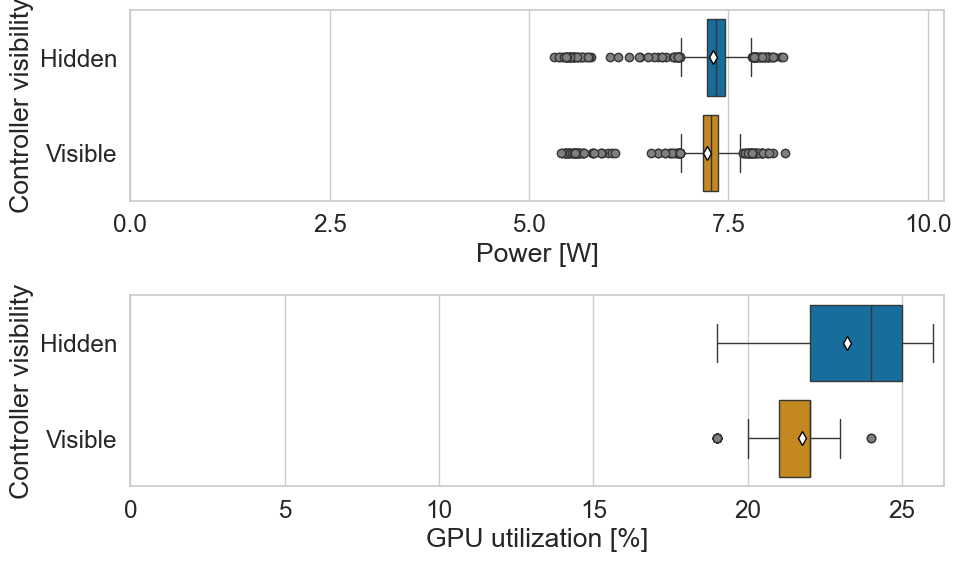

In [22]:
power_df = pd.DataFrame()
gpu_df = pd.DataFrame()
for repetition in [0,1,2,3,4,5,6,7,8,9]:
    path = f'investigation\\Quest-Pro\\BeatSaber\\PopStars-Medium\\hide_controllers0.{repetition}'
    
    wa = pd.read_csv(f'{path}\\battery_manager.csv')
    wa['Timestamp'] = wa['Timestamp'] - wa['Timestamp'][0]
    if repetition%2==0:
        wa['controllers'] = 'Hidden'
    else:
        wa['controllers'] = 'Visible'
    power_df = pd.concat([power_df, wa])

    gpu_wa = pd.read_csv(f'{path}\\logcat_VrApi.csv')
    gpu_wa['timestamp'] = gpu_wa['timestamp'] - gpu_wa['timestamp'][0]
    gpu_wa['GPU%'] = gpu_wa['GPU%'] * 100
    if repetition%2==0:
        gpu_wa['controllers'] = 'Hidden'
    else:
        gpu_wa['controllers'] = 'Visible'
    gpu_df = pd.concat([gpu_df, gpu_wa])

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.set_theme(style="whitegrid", font_scale=1.6)

sns.boxplot(data=power_df, y='controllers', x='power', showmeans=True, meanprops=custom_mean, palette='colorblind', flierprops=custom_outliers, ax=ax[0])
ax[0].set_xlim(0, 10.2)
ax[0].set_xticks([0, 2.5, 5, 7.5, 10])
ax[0].set_ylabel('Controller visibility')
ax[0].set_xlabel('Power [W]')

sns.boxplot(data=gpu_df, y='controllers', x='GPU%', showmeans=True, meanprops=custom_mean, palette='colorblind', flierprops=custom_outliers, ax=ax[1])
ax[1].set_xlim(0)
ax[1].set_ylabel('Controller visibility')
ax[1].set_xlabel('GPU utilization [%]')
plt.tight_layout()
plt.show()